In [48]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
ls

drive/  POS_DATA.csv  sample_data/


In [52]:
pos_df = pd.read_csv('drive/MyDrive/excel_work/POS_DATA.csv')

In [6]:
date_cols = ['Start of Week', 'End of Week']
for col in date_cols:
    pos_df[col] = pd.to_datetime(pos_df[col], unit='D', origin='1899-12-30')


In [7]:
cat_cols = [
    'Country', 'Retailer', 'StoreCode', 'Storename', 'Store',
    'VendorName', 'RetailerModelCode', 'SubGroupDescription',
    'RetailerSubGroupID', 'RetailerSubGroupDesc', 'MG2',
    'MG2Description', 'MG5', 'MODELCODE'
]
pos_df[cat_cols] = pos_df[cat_cols].astype('category')


In [8]:
num_cols = ['SubGroupID', 'Quantity', 'SalesAmount', 'LocalAmount']
pos_df[num_cols] = pos_df[num_cols].apply(pd.to_numeric, downcast='integer')
pos_df['Quantity'] = pos_df['Quantity'].fillna(0)
pos_df['Quantity'] = pos_df['Quantity'].astype(int)
# 1. Identify the most recent date in your dataset
max_date = pos_df['Start of Week'].max()

In [9]:
cutoff_date = max_date - pd.Timedelta(weeks=11)


In [10]:
pos_df_last_12 = pos_df[pos_df['Start of Week'] >= cutoff_date].copy()

In [11]:
pos_df_last_12['Week_Num'] = pos_df_last_12['Start of Week'].dt.isocalendar().week

In [12]:
summary = pos_df_last_12.groupby([ 'MG2Description', 'VendorName','Week_Num'], observed=True)['Quantity'].sum().reset_index()

In [13]:
summary = summary.sort_values([ 'MG2Description','VendorName', 'Week_Num'])

In [14]:
wide_summary = summary.pivot_table(
    index=[ 'MG2Description','VendorName'],   # Use VendorName as the rows
    columns='Week_Num',   # Use Week_Num as the columns
    values='Quantity', # Fill the cells with Quantity values
    fill_value=0,
    observed=True,
).reset_index() # Reset index to make VendorName a regular column

In [15]:
wide_summary.columns = [
    f'Week {col}' if col not in [ 'MG2Description','VendorName'] else col
    for col in wide_summary.columns
]

In [16]:
wide_summary = wide_summary.sort_values(['MG2Description','VendorName'])

In [17]:
vendor_totals = wide_summary.copy()

In [18]:
week_cols = [col for col in wide_summary.columns if col.startswith('Week ')]

In [19]:
vendor_totals['Total_Qty'] = vendor_totals[week_cols].sum(axis=1)

In [20]:
def categorize_vendors(group):
    # Sort by total quantity descending
    group_sorted = group.sort_values('Total_Qty', ascending=False)

    # Get top 3 vendors (excluding PANASONIC if it's in top 3, we'll add it separately)
    top_3_non_panasonic = group_sorted[group_sorted['VendorName'] != 'PANASONIC'].head(2)['VendorName'].tolist()

    # Check if PANASONIC exists in this group
    has_panasonic = 'PANASONIC' in group['VendorName'].values

    # Create the list of vendors to keep
    vendors_to_keep = top_3_non_panasonic.copy()
    if has_panasonic:
        vendors_to_keep.append('PANASONIC')

    # Mark vendors
    group['Vendor_Category'] = group['VendorName'].apply(
        lambda x: x if x in vendors_to_keep else 'Others'
    )

    return group

In [21]:
vendor_totals = vendor_totals.groupby('MG2Description', observed=True).apply(categorize_vendors, include_groups=False).reset_index()

In [22]:
result = vendor_totals.groupby(['MG2Description', 'Vendor_Category'], observed=True)[week_cols].sum().reset_index()

In [23]:
all_mg2 = result['MG2Description'].unique()
rows_to_add = []

for mg2 in all_mg2:
    mg2_vendors = result[result['MG2Description'] == mg2]['Vendor_Category'].values
    if 'PANASONIC' not in mg2_vendors:
        # Create a row with zeros for PANASONIC
        new_row = {'MG2Description': mg2, 'Vendor_Category': 'PANASONIC'}
        for col in week_cols:
            new_row[col] = 0
        rows_to_add.append(new_row)

In [24]:
if rows_to_add:
    result = pd.concat([result, pd.DataFrame(rows_to_add)], ignore_index=True)

In [25]:
result = result.rename(columns={'Vendor_Category': 'VendorName'})

# Calculate total for sorting
result['Total_Qty'] = result[week_cols].sum(axis=1)

In [26]:
# Create a custom sort order: PANASONIC first, then by total quantity descending, then Others last
def sort_key(row):
    if row['VendorName'] == 'PANASONIC':
        return (0, 0, row['VendorName'])  # PANASONIC first
    elif row['VendorName'] == 'Others':
        return (2, 0, row['VendorName'])  # Others last
    else:
        return (1, -row['Total_Qty'], row['VendorName'])  # Top 3 sorted by quantity (descending)


In [27]:
result['sort_key'] = result.apply(sort_key, axis=1)
result = result.sort_values(['MG2Description', 'sort_key'])
result = result.drop(['sort_key', 'Total_Qty'], axis=1)

In [28]:
final_rows = []

In [29]:
for mg2 in result['MG2Description'].unique():
    # Get all rows for this MG2Description
    mg2_data = result[result['MG2Description'] == mg2]

    # Add all vendor rows
    for idx, (_, row) in enumerate(mg2_data.iterrows()):
        row_dict = row.to_dict()
        # Only show MG2Description in the first row of each group
        if idx > 0:
            row_dict['MG2Description'] = ''
        final_rows.append(row_dict)

    # Calculate subtotal for this MG2Description
    subtotal_row = {'MG2Description': '', 'VendorName': 'SUBTOTAL'}
    for col in week_cols:
        subtotal_row[col] = mg2_data[col].sum()
    final_rows.append(subtotal_row)

    # Add empty row for separation
    empty_row = {'MG2Description': '', 'VendorName': ''}
    for col in week_cols:
        empty_row[col] = ''
    final_rows.append(empty_row)

In [30]:
final_result = pd.DataFrame(final_rows)
final_result

,MG2Description,VendorName,Week 40,Week 41,Week 42,Week 43,Week 44,Week 45,Week 46,Week 47,Week 48,Week 49,Week 50,Week 51
0,DRYER,PANASONIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,,SAMSUNG,6.0,9.0,7.0,6.0,25.0,9.0,5.0,14.0,9.0,12.0,15.0,12.0
2,,CANDY,7.0,8.0,7.0,7.0,29.0,7.0,5.0,7.0,15.0,17.0,6.0,10.0
3,,Others,43.0,39.0,55.0,42.0,124.0,45.0,42.0,43.0,52.0,34.0,42.0,47.0
4,,SUBTOTAL,56.0,56.0,69.0,55.0,178.0,61.0,52.0,64.0,76.0,63.0,63.0,69.0
5,,,,,,,,,,,,,,
6,WM FRONT LOADER,PANASONIC,54.0,59.0,59.0,68.0,276.0,161.0,47.0,72.0,43.0,37.0,164.0,271.0
7,,SAMSUNG,77.0,72.0,132.0,621.0,655.0,47.0,77.0,84.0,141.0,237.0,161.0,111.0
8,,LG,109.0,83.0,173.0,421.0,488.0,160.0,68.0,65.0,171.0,182.0,178.0,129.0
9,,Others,500.0,423.0,1609.0,495.0,888.0,445.0,441.0,487.0,526.0,550.0,474.0,484.0


In [31]:
import matplotlib.pyplot as plt

In [32]:
plot_data = result

In [33]:
week_cols = [col for col in plot_data.columns if col.startswith('Week ')]

In [34]:
# Convert week columns to numeric
for col in week_cols:
    plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce').fillna(0)

In [35]:
mg2_categories = plot_data['MG2Description'].unique()
mg2_categories

array(['DRYER', 'WM FRONT LOADER', 'WM TOP LOADER', 'WM TWIN TUB',
       'WM TWIN WASHER', 'WM WASHER & DRYER'], dtype=object)

In [36]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

In [37]:
mg2_data = plot_data[plot_data['MG2Description'] == 'WM FRONT LOADER']

In [38]:
mg2_data.drop(columns='MG2Description')

,VendorName,Week 40,Week 41,Week 42,Week 43,Week 44,Week 45,Week 46,Week 47,Week 48,Week 49,Week 50,Week 51
5,PANASONIC,54.0,59.0,59.0,68.0,276.0,161.0,47.0,72.0,43.0,37.0,164.0,271.0
6,SAMSUNG,77.0,72.0,132.0,621.0,655.0,47.0,77.0,84.0,141.0,237.0,161.0,111.0
3,LG,109.0,83.0,173.0,421.0,488.0,160.0,68.0,65.0,171.0,182.0,178.0,129.0
4,Others,500.0,423.0,1609.0,495.0,888.0,445.0,441.0,487.0,526.0,550.0,474.0,484.0


In [39]:
# Melt the data to long format for plotting
melted_data = mg2_data.melt(id_vars=['MG2Description', 'VendorName'],
                            value_vars=week_cols,
                            var_name='Week',
                            value_name='Quantity')

# Extract week number
melted_data['Week_Num'] = melted_data['Week'].str.extract(r'(\d+)').astype(int)

# Sort by Week_Num
melted_data = melted_data.sort_values('Week_Num')

In [40]:
# Calculate total quantity per week
melted_data['Total_Qty'] = melted_data.groupby('Week_Num')['Quantity'].transform('sum')

# Calculate market share
melted_data['Market_Share'] = (melted_data['Quantity'] / melted_data['Total_Qty']) * 100

In [41]:
from scipy.interpolate import interp1d

In [42]:
# Manually assign colors to specific vendors
vendor_colors = {
    'PANASONIC': '#1428A0',  # Grey
    'SAMSUNG' : '#6b6b6b',
    'LG': '#A50034',
    'Others': '#2ca02c',    # Green
    # Add more as needed, e.g., 'VendorName': '#color'
}

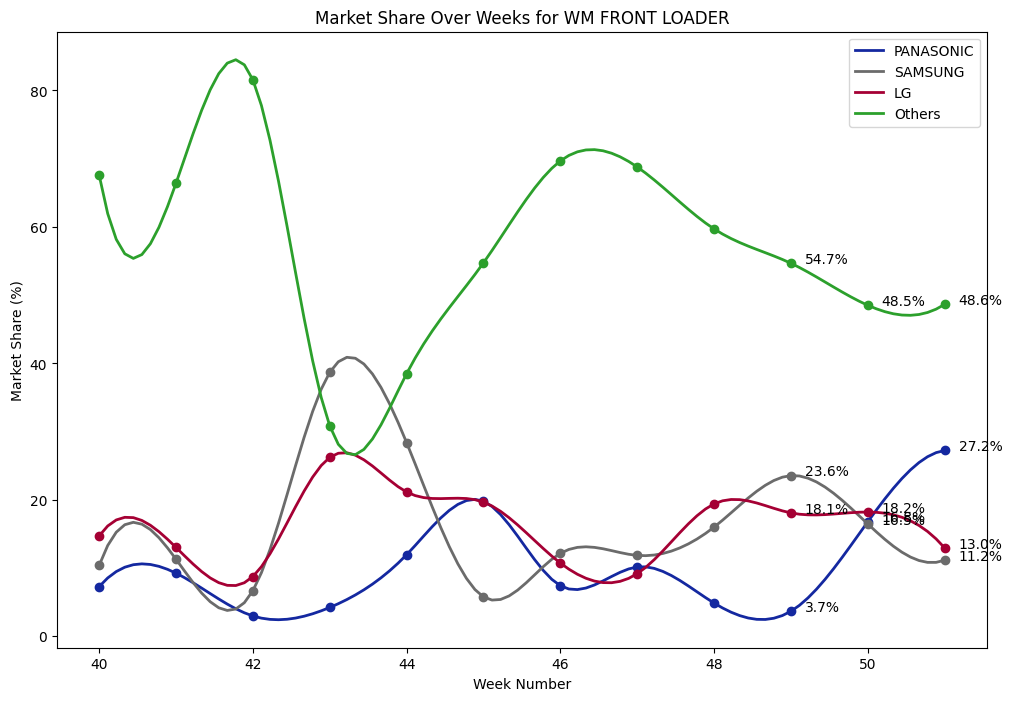

In [ ]:
# Plot the market share line chart
plt.figure(figsize=(12, 8))

for vendor in melted_data['VendorName'].unique():
    vendor_data = melted_data[melted_data['VendorName'] == vendor].sort_values('Week_Num')
    x = vendor_data['Week_Num'].values
    y = vendor_data['Market_Share'].values

    # Get color for this vendor, default to automatic if not specified
    color = vendor_colors.get(vendor, None)

    if len(x) > 1:
        # Smooth the line using cubic interpolation
        f = interp1d(x, y, kind='cubic')
        x_new = np.linspace(x.min(), x.max(), 100)
        y_new = f(x_new)
        line, = plt.plot(x_new, y_new, label=vendor, linewidth=2, color=color)
        # Add markers on original points
        plt.plot(x, y, 'o', color=line.get_color(), markersize=6)
    else:
        plt.plot(x, y, label=vendor, marker='o', linewidth=2, markersize=6, color=color)

    # Add data labels to the last 3 datapoints with change from previous
    for i in range(1, 4):
        if len(x) >= i:
            idx = -i
            label_x = x[idx]
            label_y = y[idx]
            label_text = f'{label_y:.1f}%'
            if idx > 0:  # If there's a previous point
                change = label_y - y[idx - 1]
                label_text += f' ({change:+.1f}%)'
            plt.annotate(label_text, (label_x, label_y), textcoords="offset points", xytext=(10, 0), ha='left', fontsize=10)

plt.title('Market Share Over Weeks for WM FRONT LOADER')
plt.xlabel('Week Number')
plt.ylabel('Market Share (%)')
plt.legend()
plt.show()

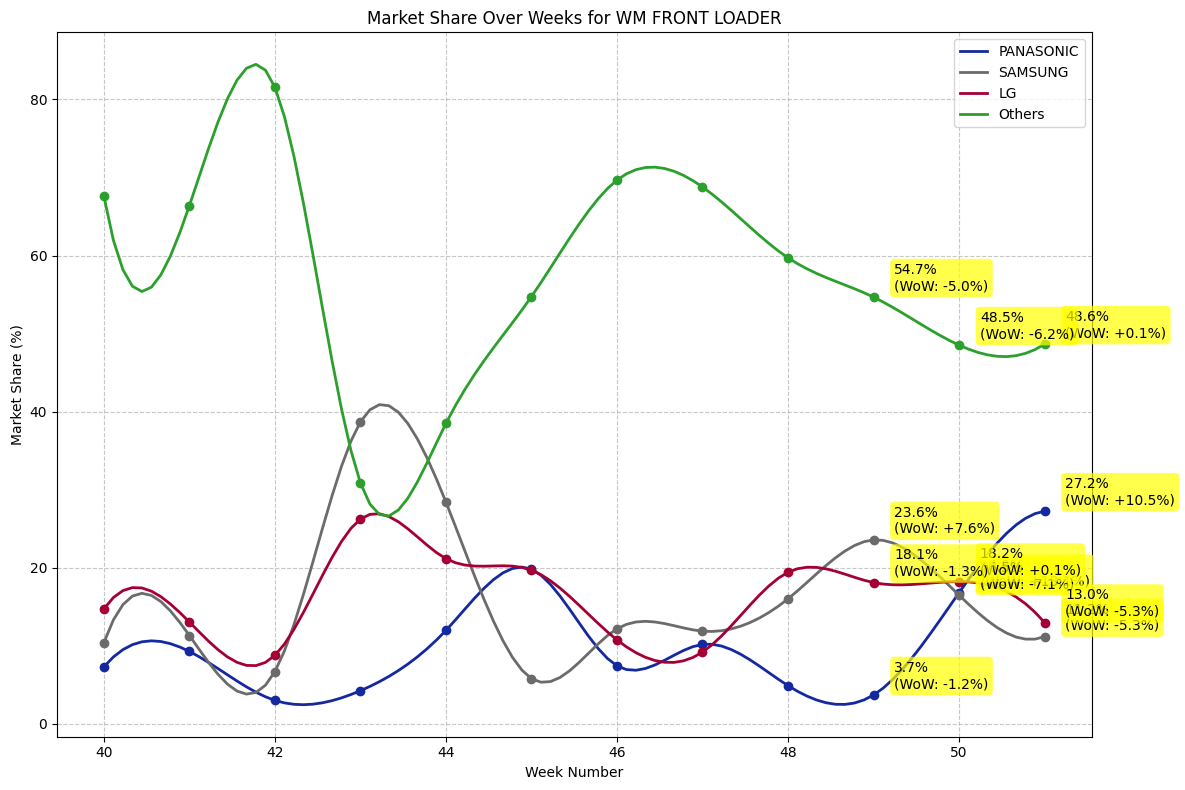

In [47]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Plot the market share line chart
plt.figure(figsize=(12, 8))

for vendor in melted_data['VendorName'].unique():
    vendor_data = melted_data[melted_data['VendorName'] == vendor].sort_values('Week_Num')
    x = vendor_data['Week_Num'].values
    y = vendor_data['Market_Share'].values

    # Get color for this vendor, default to automatic if not specified
    color = vendor_colors.get(vendor, None)

    if len(x) > 1:
        # Smooth the line using cubic interpolation
        f = interp1d(x, y, kind='cubic')
        x_new = np.linspace(x.min(), x.max(), 100)
        y_new = f(x_new)
        line, = plt.plot(x_new, y_new, label=vendor, linewidth=2, color=color)
        # Add markers on original points
        plt.plot(x, y, 'o', color=line.get_color(), markersize=6)
    else:
        plt.plot(x, y, label=vendor, marker='o', linewidth=2, markersize=6, color=color)

    # Add data labels to the last 3 datapoints with change from previous
    last_n = min(3, len(x))  # Handle cases where there are fewer than 3 points
    for i in range(last_n):
        idx = -(i + 1)  # This gives us -1, -2, -3
        label_x = x[idx]
        label_y = y[idx]
        label_text = f'{label_y:.1f}%'

        # Calculate WoW change (compare with the point before this one)
        if len(x) + idx > 0:  # Check if there's a previous point
            prev_idx = idx - 1
            change = label_y - y[prev_idx]
            label_text += f'\n(WoW: {change:+.1f}%)'

        # Increased fontsize and adjusted xytext for better visibility
        plt.annotate(label_text, (label_x, label_y), textcoords="offset points",
                    xytext=(15, 5), ha='left', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="b", lw=0, alpha=0.7))

plt.title('Market Share Over Weeks for WM FRONT LOADER')
plt.xlabel('Week Number')
plt.ylabel('Market Share (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()